In [1]:
import ROOT
%jsroot on

import numpy
import root_numpy
import pandas
import xgboost
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
import utils
import tmva_utils
import math

from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier  

Welcome to JupyROOT 6.10/09


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-elfike2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def GetDatasets(inputfile, extraBranches, mySelection, branchName, labelName):
    train_frac = 0.5
    f = ROOT.TFile(inputfile, 'UPDATE')
    #f = ROOT.TFile("/home/users/hmei/ttH/Loopers/MVABaby_ttHHadronic_multiClass_promptness_toptag.root", 'UPDATE')
    tree = f.Get("t")

    # load tree to array
    #feature_names = (root_numpy.tree2array(tree, branches = ["mva_branches"], start=0, stop=1))[0][0]
    feature_names = (root_numpy.tree2array(tree, branches = [branchName], start=0, stop=1))[0][0]
    feature_names = list(feature_names) 
    
    #feature2_names = (root_numpy.tree2array(tree, branches = ["mva_branches_2"], start=0, stop=1))[0][0]
    #feature2_names = list(feature2_names)
#    feature_names = feature_names[1:len(feature_names)]
    print feature_names
    #print feature2_names
    
    allBranches = numpy.concatenate( (feature_names, extraBranches) )
    features_raw = root_numpy.tree2array(tree, branches = allBranches, selection = mySelection) 
    #allBranches2 = numpy.concatenate( (feature2_names, extraBranches) )
    #features2_raw = root_numpy.tree2array(tree, branches = allBranches2, selection = mySelection + "&& label_ttH_ttgg_bdt_ < 2") 
    
    # print features_raw
    features = []
    #features2 = []
    
    for feature in feature_names:
        features.append(features_raw[feature])
    #for feature2 in feature2_names:
    #    features2.append(features2_raw[feature2])

    #features = numpy.asarray(features)
    features = numpy.transpose(features)
    #features2 = numpy.transpose(features2)
    
    labels = root_numpy.tree2array(tree, branches = labelName, selection = mySelection)
    #labels = root_numpy.tree2array(tree, branches = "label_", selection = mySelection)
    #labels2 = root_numpy.tree2array(tree, branches = "label_ttH_ttgg_bdt_", selection = mySelection + "&& label_ttH_ttgg_bdt_ < 2")
    weights = root_numpy.tree2array(tree, branches = "evt_weight_", selection = mySelection) 
    #weights2 = root_numpy.tree2array(tree, branches = "evt_weight_", selection = mySelection + "&& label_ttH_ttgg_bdt_ < 2") 

    extra_arrays = {}
    for extraBranch in extraBranches:
        type_ = features_raw[extraBranch].dtype
        extra_arrays[extraBranch] = numpy.array( features_raw[extraBranch], dtype = [(extraBranch, type_)] )

    return features, labels, weights, extra_arrays

In [3]:
def Train1(d_train, d_test, doBinary, n_round, sum_neg_weights = 1, sum_pos_weights = 1):
    # Define BDT parameters
    param1 = { 
    	    'max_depth': 8,
            'eta': 0.3,
            'objective': 'multi:softprob',#'multi:softmax',
            'num_class': 5,
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'nthread' : 8,
            }
    
    param2 = { 
    	    'max_depth': 8,
            'eta': 0.3,
            'objective': 'binary:logistic',
#            'scale_pos_weight': sum_neg_weights / sum_pos_weights,
            'subsample': 1,
            'colsample_bytree': 1.0,
            'nthread' : 8,
            }

    #n_round = 100
    evallist = [(d_train, 'train'), (d_test, 'test')]
    progress = {}

    #clf, y_pred, y_pred_prob = prec_xgb(100, 8, x_train, y_train, x_test, y_test, weights_train1)
    #print y_pred, y_pred_prob
    param = param1
    if doBinary:
        param = param2
    bdt = xgboost.train(param, d_train, n_round, evallist, evals_result = progress)	

    d_pred_train = bdt.predict(d_train)#, output_margin=True)
    d_pred_test = bdt.predict(d_test)#, output_margin=True)

    return d_pred_train, d_pred_test, bdt

In [4]:
nround1 = 100
#nround2 = 100

#filename = "../Loopers/MVABaby_ttHHadronic_multiClass_promptness_toptag_forHggMeeting.root"
filename = "../Loopers/MVABaby_ttHHadronic_multiClass_promptness_toptag6.root"
outname = "test_multiclass_2BDTs"

features1_train, labels1_train, weights1_train, extraArrays_train = GetDatasets(filename, ["evt_weight_", "process_id_", "mass_"], "label_ttH_ttgg_bdt_ < 2 && rand_ < 0.5 && topTag_pT_ > 0", "mva_branches_2", "label_ttH_ttgg_bdt_")
features1_test, labels1_test, weights1_test, extraArrays_test = GetDatasets(filename, ["evt_weight_", "process_id_", "mass_"], "label_ttH_ttgg_bdt_ < 2 && rand_ > 0.5", "mva_branches_2", "label_ttH_ttgg_bdt_")

#scale_sig = utils.sum_of_weights(weights_train, labels_train, 0)
#scale_bkg1 = utils.sum_of_weights(weights_train, labels_train, 1)
#scale_bkg2 = utils.sum_of_weights(weights_train, labels_train, 2)
#scale_bkg3 = utils.sum_of_weights(weights_train, labels_train, 3)
#scale_bkg4 = utils.sum_of_weights(weights_train, labels_train, 4)
#scale_bkg = scale_bkg1 + scale_bkg2 + scale_bkg3 + scale_bkg4
#for i in range(len(weights_train)):
#    if labels_train[i] == 0:
#        weights_train[i] *= scale_bkg/scale_sig
sum_neg_weights_1 = utils.sum_of_weights(weights1_train, labels1_train, 0)
sum_pos_weights_1 = utils.sum_of_weights(weights1_train, labels1_train, 1)
        
d_train_1 = xgboost.DMatrix(features1_train, label = labels1_train, weight = weights1_train)
d_test_1 = xgboost.DMatrix(features1_test, label = labels1_test)

# first training of a binary BDT separating ttH vs ttgg (PP)
d_pred_train_1, d_pred_test_1, bdt1 = Train1(d_train_1, d_test_1, True, nround1, sum_neg_weights_1, sum_pos_weights_1)


['topTag_pT_', 'topTag_eta_', 'topTag_phi_', 'topTag_topMass_', 'leadptoM_', 'subleadptoM_', 'lead_eta_', 'sublead_eta_', 'lead_phi_', 'sublead_phi_']
['topTag_pT_', 'topTag_eta_', 'topTag_phi_', 'topTag_topMass_', 'leadptoM_', 'subleadptoM_', 'lead_eta_', 'sublead_eta_', 'lead_phi_', 'sublead_phi_']
[0]	train-error:0.072939	test-error:0.619896
[1]	train-error:0.072939	test-error:0.619896
[2]	train-error:0.072939	test-error:0.619896
[3]	train-error:0.072939	test-error:0.619896
[4]	train-error:0.072939	test-error:0.619896
[5]	train-error:0.072939	test-error:0.619896
[6]	train-error:0.072939	test-error:0.619896
[7]	train-error:0.072939	test-error:0.619896
[8]	train-error:0.072939	test-error:0.619896
[9]	train-error:0.072939	test-error:0.619896
[10]	train-error:0.073887	test-error:0.611013
[11]	train-error:0.073831	test-error:0.609803
[12]	train-error:0.072985	test-error:0.613139
[13]	train-error:0.073766	test-error:0.608376
[14]	train-error:0.073489	test-error:0.605419
[15]	train-error:0

[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[06:28:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5

In [5]:
%matplotlib inline
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt

In [6]:
ttH_score = ROOT.TH1F("ttH_score", "", 100, 0, 1)
ttGG_score = ROOT.TH1F("ttGG_score", "", 100, 0, 1)
for i in range(len(d_pred_test_1)):
    if labels1_test[i] == 1: 
        ttH_score.Fill(d_pred_test_1[i])
    if labels1_test[i] == 0: 
        ttGG_score.Fill(d_pred_test_1[i])
c = ROOT.TCanvas("c", "", 500,500)
ttH_score.Draw("hist")
ttH_score.GetXaxis().SetTitle("BDT score")
ttGG_score.Draw("hist same")
ttGG_score.SetLineColor(2)
ttH_score.SetStats(0)
ttGG_score.SetStats(0)
c.SaveAs("/home/users/hmei/public_html/2018/20181018_ttH_had/ttH_ttGG.png")
c.SaveAs("/home/users/hmei/public_html/2018/20181018_ttH_had/ttH_ttGG.pdf")
c.Draw()

features2_train, labels2_train, weights2_train, extraArrays2_train = GetDatasets(filename, ["evt_weight_", "process_id_", "mass_"], "label_ < 5 && rand_ < 0.5", "mva_branches_2", "label_ttH_ttgg_bdt_")
features2_test, labels2_test, weights2_test, extraArrays2_test = GetDatasets(filename, ["evt_weight_", "process_id_", "mass_"], "label_ < 5 && rand_ > 0.5", "mva_branches_2", "label_ttH_ttgg_bdt_")
d_train_2 = xgboost.DMatrix(features2_train, label = labels2_train, weight = weights2_train)
d_test_2 = xgboost.DMatrix(features2_test, label = labels2_test, weight = weights2_test)
d_pred2_train = bdt1.predict(d_train_2)
d_pred2_test = bdt1.predict(d_test_2)

print d_pred2_train
print d_pred2_test

['topTag_pT_', 'topTag_eta_', 'topTag_phi_', 'topTag_topMass_', 'leadptoM_', 'subleadptoM_', 'lead_eta_', 'sublead_eta_', 'lead_phi_', 'sublead_phi_']
['topTag_pT_', 'topTag_eta_', 'topTag_phi_', 'topTag_topMass_', 'leadptoM_', 'subleadptoM_', 'lead_eta_', 'sublead_eta_', 'lead_phi_', 'sublead_phi_']
[0.20535977 0.09773209 0.3586282  ... 0.16629805 0.08100283 0.04185675]
[0.24025097 0.13126618 0.04145998 ... 0.05038723 0.11539806 0.04601454]


Info in <TCanvas::Print>: png file /home/users/hmei/public_html/2018/20181018_ttH_had/ttH_ttGG.png has been created
Info in <TCanvas::Print>: pdf file /home/users/hmei/public_html/2018/20181018_ttH_had/ttH_ttGG.pdf has been created


In [7]:
import sys

features3_train, labels3_train, weights3_train, extraArrays3_train = GetDatasets(filename, ["evt_weight_", "process_id_", "mass_"], "label_ < 5 && rand_ < 0.5", "mva_branches", "label_")
features3_test, labels3_test, weights3_test, extraArrays3_test = GetDatasets(filename, ["evt_weight_", "process_id_", "mass_"], "label_ < 5 && rand_ > 0.5", "mva_branches", "label_")

features3_train = numpy.concatenate((features3_train, d_pred2_train[:,None]),axis=1)
features3_test = numpy.concatenate((features3_test, d_pred2_test[:,None]),axis=1)

print features3_train
print labels3_train
print weights3_train


scale_sig = utils.sum_of_weights(weights3_train, labels3_train, 0)
scale_bkg1 = utils.sum_of_weights(weights3_train, labels3_train, 1)
scale_bkg2 = utils.sum_of_weights(weights3_train, labels3_train, 2)
scale_bkg3 = utils.sum_of_weights(weights3_train, labels3_train, 3)
scale_bkg4 = utils.sum_of_weights(weights3_train, labels3_train, 4)
scale_bkg = scale_bkg1 + scale_bkg2 + scale_bkg3 + scale_bkg4

#for i in range(len(weights3_train)):
#    if labels3_train[i] == 0:
#        weights3_train[i] *= scale_bkg/scale_sig



d_train_3 = xgboost.DMatrix(features3_train, label = labels3_train, weight = weights3_train)
d_test_3 = xgboost.DMatrix(features3_test, label = labels3_test)

# first training of a multi-class BDT
d_pred_train, d_pred_test, bdt2 = Train1(d_train_3, d_test_3, False, nround1)

print d_pred_test

# modify label
labels3_train[labels3_train > 0] = -1
labels3_train[labels3_train == 0] = 1
labels3_train[labels3_train == -1] = 0

labels3_test[labels3_test > 0] = -1
labels3_test[labels3_test == 0] = 1
labels3_test[labels3_test == -1] = 0

'''
# change training weight for binary output BDT
sum_neg_weights = utils.sum_of_weights(weights_train, labels_train, 0)
sum_pos_weights = utils.sum_of_weights(weights_train, labels_train, 1)
d_train = xgboost.DMatrix(d_pred_train_1, label = labels1_train, weight = weights_train)
d_test = xgboost.DMatrix(d_pred_test_1, label = labels1_test)
# second training of a binary BDT
d_pred_train2, d_pred_test2 = Train1(d_train, d_test, True, nround2, sum_neg_weights, sum_pos_weights)
'''
# save information into a root tree
arrays_forTree = []
for key in extraArrays3_test:
    arrays_forTree.append( extraArrays3_test[key] )
#arrays_forTree.append( numpy.array( d_pred_test2, dtype = [("mva_score_", numpy.float64)] ) ) 
arrays_forTree.append( numpy.array( d_pred_test[:,0], dtype = [("mva_score1_", numpy.float64)] ) ) 
arrays_forTree.append( numpy.array( labels3_test, dtype = [("label_", numpy.float64)] ) ) 

hfile = ROOT.TFile('rootfiles/' + outname + ".root","RECREATE");
tree_out = root_numpy.array2tree(numpy.transpose(arrays_forTree[0]))
for i in range(1, len(arrays_forTree)):
    root_numpy.array2tree(numpy.transpose(arrays_forTree[i]), tree=tree_out)

tree_out.Print()
hfile.Write()
hfile.Close()

['topTag_score_', 'dipho_delta_R', 'njets_', 'ht_', 'leadptoM_', 'subleadptoM_', 'maxIDMVA_', 'minIDMVA_', 'lead_eta_', 'sublead_eta_', 'jet1_pt_', 'jet1_eta_', 'jet1_btag_', 'jet2_pt_', 'jet2_eta_', 'jet2_btag_', 'jet3_pt_', 'jet3_eta_', 'jet3_btag_', 'jet4_pt_', 'jet4_eta_', 'jet4_btag_', 'jet5_pt_', 'jet5_eta_', 'jet5_btag_', 'jet6_pt_', 'jet6_eta_', 'jet6_btag_', 'max1_btag_', 'max2_btag_', 'leadPSV_', 'subleadPSV_', 'dipho_cosphi_', 'dipho_rapidity_', 'met_', 'nb_loose_']
['topTag_score_', 'dipho_delta_R', 'njets_', 'ht_', 'leadptoM_', 'subleadptoM_', 'maxIDMVA_', 'minIDMVA_', 'lead_eta_', 'sublead_eta_', 'jet1_pt_', 'jet1_eta_', 'jet1_btag_', 'jet2_pt_', 'jet2_eta_', 'jet2_btag_', 'jet3_pt_', 'jet3_eta_', 'jet3_btag_', 'jet4_pt_', 'jet4_eta_', 'jet4_btag_', 'jet5_pt_', 'jet5_eta_', 'jet5_btag_', 'jet6_pt_', 'jet6_eta_', 'jet6_btag_', 'max1_btag_', 'max2_btag_', 'leadPSV_', 'subleadPSV_', 'dipho_cosphi_', 'dipho_rapidity_', 'met_', 'nb_loose_']
[[-3.74841779e-01  1.88729274e+00  5

[06:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 210 extra nodes, 0 pruned nodes, max_depth=8
[06:29:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=8
[06:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 266 extra nodes, 0 pruned nodes, max_depth=8
[06:29:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=8
[06:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[06:29:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=8
[06:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 0 pruned nodes, max_depth=8
[06:29:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes,

In [8]:
f_za = ROOT.TFile('rootfiles/'+outname+'.root')
tree_test = f_za.Get("tree")

var = "mva_score1_"
signal_mva_scores = root_numpy.tree2array(tree_test, branches = [var], selection = "label_ == 1")

n_quantiles = 100
quantiles, mva_cut = utils.quantiles_to_mva_score(n_quantiles, signal_mva_scores)

print "Significance estimate sfor our BDT: s, b_mc, b_data, z_mc, z_data"
nGrid = 100

datafile_path = "txtfiles/" + outname + ".txt"

with open(datafile_path, 'w+') as datafile_id:

    for i in range(nGrid):
        selection_base = var + "> %.10f" % ( mva_cut[i][0])#, mva_cut2[n_quantiles2-j-1][0])                                                                                                                
        s,z_mc,z_unc_mc,z_data,z_unc_data = utils.calc_significance2(tree_test, selection_base, i, mva_cut[i][0], 'dummy')
        datafile_id.write(str(s) + ' ' + str(z_mc) + ' ' + str(z_unc_mc) + '\n')                                                                                                                                     

datafile_id.close()

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0] [(0.72609669,), (0.62636805,), (0.55619603,), (0.49480498,), (0.44343022,), (0.39560166,), (0.35586959,), (0.31930056,), (0.28933179,), (0.26025534,), (0.23486732,), (0.21258964,), (0.19353504,), (0.17675371,), (0.16171965,), (0.1490218,), (0.13739829,), (0.12704606,), (0.11695802,), (0.10845421,), (0.10072578,), (0.0937845,), (0.08729846,), (0.08151509,), (0.07567243,), (0.0702216,), (0.06580016,), (0.061

In [10]:
def prepareInputs(inputs, colors, styles, keysForPlot, txtfiles, colorlists, linestyles):
    for i in range(len(keysForPlot)):
        inputs[keysForPlot[i]] = numpy.loadtxt(txtfiles[i], usecols=(0,1,2), unpack=True)
        colors[keysForPlot[i]] = colorlists[i]
        styles[keysForPlot[i]] = linestyles[i]

{'test': 'g', 'multi': 'b'} {'test': '--', 'multi': '-'}


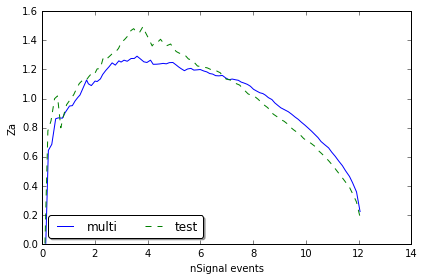

In [11]:
keysForPlot = ["multi", "test"]
txtfiles = ["txtfiles/test_multiclass.txt", "txtfiles/test_multiclass_2BDTs.txt"]
colorlists = ["b","g"]
linestyles = ["-","--"]

inputs = {}
colors = {}
styles = {}

prepareInputs(inputs, colors, styles, keysForPlot, txtfiles, colorlists, linestyles)

print colors, styles

fig = plt.figure()
fig, ax1 = plt.subplots()

for key in keysForPlot:
#  if key ==  "sig_1_bkg_1" or key == "sig_1_bkg_0.5":
    ax1.plot(inputs[key][0], inputs[key][1], color=colors[key], label=key, linestyle = styles[key])
    #linestyle = '--', dashes = (5,2)

ax1.legend(loc="lower left", #bbox_to_anchor=[0, 1],                                                                                                                                                        
           ncol=2, shadow=True, fancybox=True)
ax1.set_xlabel('nSignal events')
ax1.set_ylabel('Za')


fig.tight_layout()
#plt.show() 
plt.savefig("/home/users/hmei/public_html/2018/20181018_ttH_had/test2.pdf")